   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Saving TR.png to TR.png


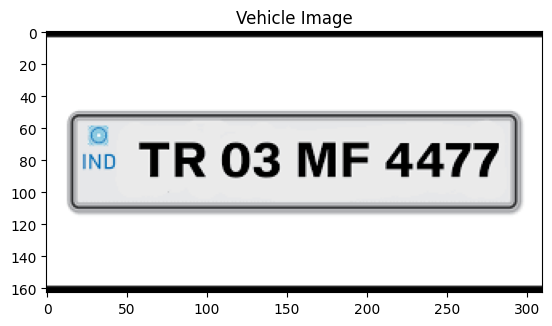

License Plate Number: TR 03 MF 4477


In [1]:
!pip install easyocr opencv-python-headless pytesseract
!sudo apt install tesseract-ocr

import cv2
import numpy as np
import easyocr
import pytesseract
import matplotlib.pyplot as plt
import imutils

# Initialize OCR readers
reader_easyocr = easyocr.Reader(['en'])

def recognize_license_plate(image_path, reader='easyocr', enhance_ocr=True):
    """
    Recognizes license plate from an image using OpenCV and OCR.

    Args:
        image_path (str): Path to the image file.
        reader (str): 'easyocr' or 'tesseract' to select the OCR engine.
        enhance_ocr (bool): Whether to apply OCR enhancement techniques.

    Returns:
        str: Detected license plate number or None if not found.
    """
    try:
        # 1. Read and preprocess the image
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        bfilter = cv2.bilateralFilter(gray, 11, 17, 17)

        # 2. Perform edge detection
        edged = cv2.Canny(bfilter, 30, 200)

        # 3. Find contours and sort by area
        keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(keypoints)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]

        location = None
        for contour in contours:
            approx = cv2.approxPolyDP(contour, 8, True)
            if 3 <= len(approx) <= 8:
                location = approx
                break

        # 4. Isolate and crop the license plate region
        if location is not None:
            mask = np.zeros(gray.shape, np.uint8)
            new_image = cv2.drawContours(mask, [location], 0, 255, -1)
            new_image = cv2.bitwise_and(img, img, mask=mask)

            (x, y) = np.where(mask == 255)
            (x1, y1) = (np.min(x), np.min(y))
            (x2, y2) = (np.max(x), np.max(y))
            cropped_image = gray[x1:x2 + 1, y1:y2 + 1]

            # 5. Apply image preprocessing to the cropped license plate
            if enhance_ocr:
                cropped_image = cv2.GaussianBlur(cropped_image, (3, 3), 0)
                cropped_image = cv2.threshold(cropped_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
                kernel = np.ones((1, 1), np.uint8)
                cropped_image = cv2.morphologyEx(cropped_image, cv2.MORPH_OPEN, kernel)

            # 6. Perform OCR
            if reader == 'easyocr':
                result = reader_easyocr.readtext(cropped_image)
                if result:
                    text = result[0][-2]
                    if not text or len(text) < 5 and enhance_ocr:
                        result = reader_easyocr.readtext(cropped_image, detail=0, config='--psm 6')
                        text = result[0] if result else None
                else:
                    text = None
            elif reader == 'tesseract':
                text = pytesseract.image_to_string(cropped_image, config='--psm 6')
            else:
                raise ValueError("Invalid OCR reader specified. Choose 'easyocr' or 'tesseract'.")

            return text
        else:
            return None

    except Exception as e:
        print(f"Error: {e}")
        return None

# Example usage:
from google.colab import files
uploaded = files.upload()
if uploaded:
    image_path = list(uploaded.keys())[0]
    license_plate_number = recognize_license_plate(image_path, reader='easyocr', enhance_ocr=True)

    # Display the image
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Vehicle Image')
    plt.show()

    if license_plate_number:
        print(f"License Plate Number: {license_plate_number}")
    else:
        print("License plate not found in the image.")